In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [3]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [4]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

D:\AnaconDA\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [5]:
#对时间序列进行分析
#总的销售趋势2013-2015年
# train['date'] = pd.to_datetime(train.Date)
# data = train.loc[:,['Sales']]
# data = data.set_index(train.date)
# data.plot()

# weekly = data.resample('W').sum()
# weekly.plot()

# dayily = data.resample('D').sum()
# dayily.plot()

In [6]:
TESTID = test['Id']

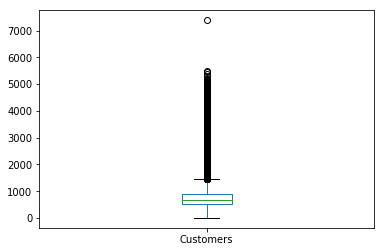

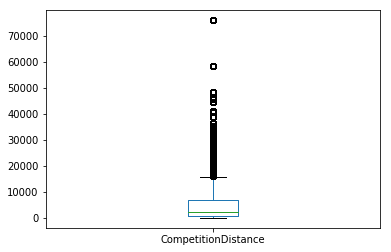

In [7]:
train.Customers.plot(kind='box')
plt.show()
train.CompetitionDistance.plot(kind='box')
plt.show()

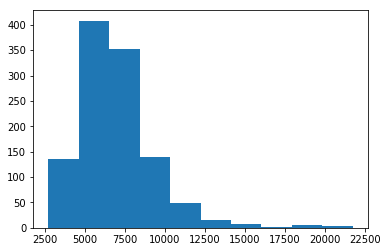

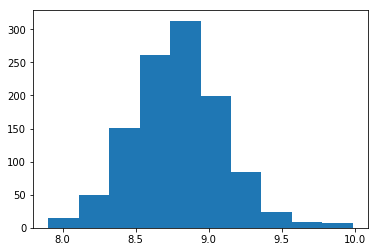

In [8]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [9]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [10]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #CART回归树不需要预处理数据和NAn值
#     distance_max = max(data.CompetitionDistance)
#     data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
#     print(data.CompetitionDistance.isnull().any())
#     min_max_scaler = MinMaxScaler()
#     scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
#     data.drop("CompetitionDistance",axis=1)
#     data['CompetitionDistance'] = scaledata
    #时间序列问题 需要考虑进时间的因素
    data['Year'] = data.Date.dt.year
    print(data['Year'].dtype)
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    
    if istrain:
        data.drop(['Store','Open','Date','Customers','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Store','Open','Date','Customers','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    else:
        data.drop(['Id','Store','Open','Date','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Id','Store','Open','Date','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    print(data.columns)

In [11]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

int64
Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
int64
Index(['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


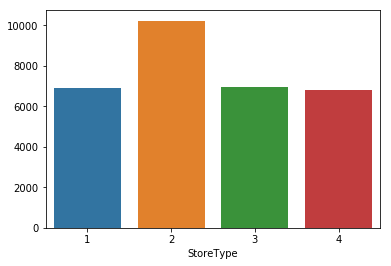

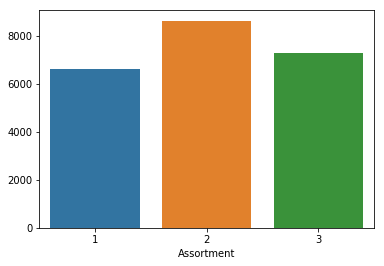

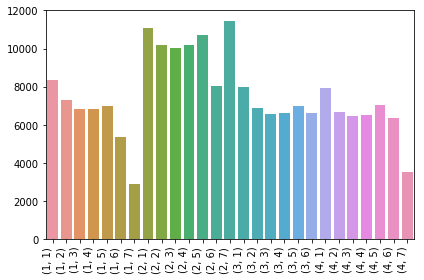

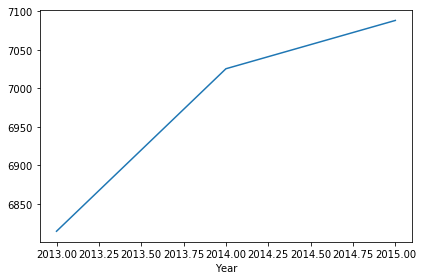

In [12]:
ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
import seaborn as sns
sns.barplot(ST_gp.index,ST_gp.values)
plt.show()

As_gp = train.groupby('Assortment')['Sales'].agg('mean')
sns.barplot(As_gp.index,As_gp.values)
plt.show()
Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#每年销售额的趋势
YearS_gp = train.groupby(['Year'])['Sales'].agg("mean")
ax2 = sns.lineplot(YearS_gp.index,YearS_gp.values)
plt.tight_layout()
plt.show()

In [13]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
print(X_train.shape)
print(X_valid.shape)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

(834259, 16)
(10133, 16)


D:\AnaconDA\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


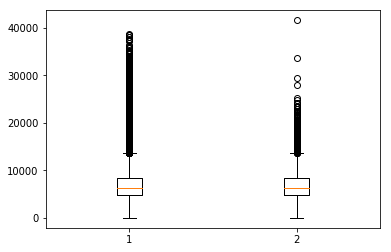

In [14]:
plt.boxplot([Y_train,Y_valid])
plt.show()

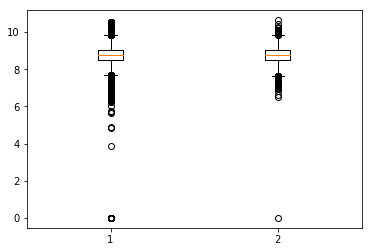

In [15]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [16]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [17]:
params = {"objective": "reg:linear",
          "eta": 0.1,
          "max_depth": 12,
          "min_child_weight":1,
          "gamma" :0,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 1000

# dtrain = xgb.DMatrix(X_train, Y_train)
# dvalid = xgb.DMatrix(X_valid, Y_valid)
# dtest = xgb.DMatrix(test)
eval_set= [(X_train, Y_train),(X_valid, Y_valid)]
#watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
ret = {}
import time
start = time.time()
estimator = xgb.XGBRegressor(max_depth=12,learning_rate =0.1,n_jobs =4, n_estimators=num_trees,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1)
estimator.fit(X_train, Y_train,eval_metric=rmspe_xg, eval_set=eval_set, verbose=True,early_stopping_rounds=20)
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()
print("Train use time:",end-start)

D:\AnaconDA\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:7.44317	validation_1-rmse:7.43873	validation_0-rmspe:0.999496	validation_1-rmspe:0.999477
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70068	validation_1-rmse:6.69677	validation_0-rmspe:0.998793	validation_1-rmspe:0.998771


KeyboardInterrupt: 

In [18]:
from matplotlib import pyplot
results = estimator.evals_result()
epochs = len(results['validation_0']['rmspe'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmspe'], label='Train')
ax.plot(x_axis, results['validation_1']['rmspe'], label='Test')
ax.legend()
pyplot.ylabel('Rmspe Loss')
pyplot.title('XGBoost Rmspe Loss')
pyplot.show()

AttributeError: 'XGBRegressor' object has no attribute 'evals_result_'

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

def customer_rmspe_xg(yhat, y):
    # y = y.values
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return rmspe

param_test1 = {
 'max_depth':range(10,13,1),
 #'subsample': [0.7,0.8,0.9],
 #'learning_rate': [0.08,0.1,0.11]
}
params_fit = {
    'eval_metric':rmspe_xg,
    'early_stopping_rounds':20,
    'eval_set':eval_set
}
nums_round = 492
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=12,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test1,cv=3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch1.fit(X_train, Y_train)

D:\AnaconDA\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] max_depth=10 ....................................................


KeyboardInterrupt: 

In [20]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [21]:
param_test2 = {
 'subsample': [0.8,0.9],
}

nums_round = 492
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test2,cv=3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch2.fit(X_train, Y_train)

D:\AnaconDA\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] subsample=0.8 ...................................................


KeyboardInterrupt: 

In [22]:
print(gsearch2.best_params_)
print(gsearch2.best_estimator_)
best_model = gsearch2.best_estimator_
from sklearn.externals import joblib
joblib.dump(best_model, "current_model.m")

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [23]:
param_test3 = {
 'eta': [0.08,0.1,0,12,0,15,0,2],
}

nums_round = 492
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch3.fit(X_train, Y_train)

D:\AnaconDA\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
D:\AnaconDA\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] eta=0.08 ........................................................


KeyboardInterrupt: 

In [24]:
print(gsearch3.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [25]:
param_test4 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

nums_round = 492
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test4,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False),fit_params = params_fit)
gsearch4.fit(X_train, Y_train)

D:\AnaconDA\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=0.0 .......................................................


KeyboardInterrupt: 

In [26]:
print(gsearch4.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [37]:

estimator = xgb.XGBRegressor(max_depth=10,learning_rate =0.1,n_jobs =4, gamma = 0.4,n_estimators=num_trees,subsample=0.8,colsample_bytree=0.7,nthread=4,scale_pos_weight=1)
estimator.fit(X_train, Y_train,eval_metric=rmspe_xg, eval_set=eval_set, verbose=True,early_stopping_rounds=20)

[0]	validation_0-rmse:7.44335	validation_1-rmse:7.43882	validation_0-rmspe:0.999495	validation_1-rmspe:0.999475
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.7012	validation_1-rmse:6.69701	validation_0-rmspe:0.998787	validation_1-rmspe:0.998764
[2]	validation_0-rmse:6.03308	validation_1-rmse:6.02923	validation_0-rmspe:0.997512	validation_1-rmspe:0.997484
[3]	validation_0-rmse:5.43202	validation_1-rmse:5.42839	validation_0-rmspe:0.995361	validation_1-rmspe:0.995327
[4]	validation_0-rmse:4.89119	validation_1-rmse:4.88768	validation_0-rmspe:0.99196	validation_1-rmspe:0.991914
[5]	validation_0-rmse:4.40458	validation_1-rmse:4.40154	validation_0-rmspe:0.986869	validation_1-rmspe:0.986811
[6]	validation_0-rmse:3.96683	validation_1-rmse:3.96408	validation_0-rmspe:0.979633	validation_1-rmspe:0.979561
[7]	validation_0-rmse:3.573	validation_1-rmse:3.57037	val

[71]	validation_0-rmse:0.198362	validation_1-rmse:0.205343	validation_0-rmspe:0.245493	validation_1-rmspe:0.199463
[72]	validation_0-rmse:0.195634	validation_1-rmse:0.202713	validation_0-rmspe:0.243064	validation_1-rmspe:0.196356
[73]	validation_0-rmse:0.195091	validation_1-rmse:0.202363	validation_0-rmspe:0.242719	validation_1-rmspe:0.19605
[74]	validation_0-rmse:0.193558	validation_1-rmse:0.200895	validation_0-rmspe:0.241456	validation_1-rmspe:0.194493
[75]	validation_0-rmse:0.192641	validation_1-rmse:0.200062	validation_0-rmspe:0.240796	validation_1-rmspe:0.193648
[76]	validation_0-rmse:0.192507	validation_1-rmse:0.199957	validation_0-rmspe:0.240903	validation_1-rmspe:0.193625
[77]	validation_0-rmse:0.192036	validation_1-rmse:0.199508	validation_0-rmspe:0.240313	validation_1-rmspe:0.193193
[78]	validation_0-rmse:0.191504	validation_1-rmse:0.199016	validation_0-rmspe:0.239954	validation_1-rmspe:0.192679
[79]	validation_0-rmse:0.188995	validation_1-rmse:0.196698	validation_0-rmspe:0.2

[143]	validation_0-rmse:0.151236	validation_1-rmse:0.162486	validation_0-rmspe:0.201514	validation_1-rmspe:0.149526
[144]	validation_0-rmse:0.15106	validation_1-rmse:0.162401	validation_0-rmspe:0.201423	validation_1-rmspe:0.149457
[145]	validation_0-rmse:0.15045	validation_1-rmse:0.161905	validation_0-rmspe:0.200908	validation_1-rmspe:0.148883
[146]	validation_0-rmse:0.149903	validation_1-rmse:0.161356	validation_0-rmspe:0.200386	validation_1-rmspe:0.148219
[147]	validation_0-rmse:0.149444	validation_1-rmse:0.161016	validation_0-rmspe:0.199804	validation_1-rmspe:0.147831
[148]	validation_0-rmse:0.149252	validation_1-rmse:0.1609	validation_0-rmspe:0.1997	validation_1-rmspe:0.147723
[149]	validation_0-rmse:0.149016	validation_1-rmse:0.160649	validation_0-rmspe:0.19948	validation_1-rmspe:0.14739
[150]	validation_0-rmse:0.148834	validation_1-rmse:0.160526	validation_0-rmspe:0.199279	validation_1-rmspe:0.147253
[151]	validation_0-rmse:0.148512	validation_1-rmse:0.160222	validation_0-rmspe:0

[214]	validation_0-rmse:0.135181	validation_1-rmse:0.149563	validation_0-rmspe:0.181159	validation_1-rmspe:0.133732
[215]	validation_0-rmse:0.134987	validation_1-rmse:0.149424	validation_0-rmspe:0.180778	validation_1-rmspe:0.133571
[216]	validation_0-rmse:0.134884	validation_1-rmse:0.149338	validation_0-rmspe:0.180678	validation_1-rmspe:0.133462
[217]	validation_0-rmse:0.13467	validation_1-rmse:0.149177	validation_0-rmspe:0.18038	validation_1-rmspe:0.133234
[218]	validation_0-rmse:0.134571	validation_1-rmse:0.149079	validation_0-rmspe:0.180277	validation_1-rmspe:0.133132
[219]	validation_0-rmse:0.134525	validation_1-rmse:0.149062	validation_0-rmspe:0.180249	validation_1-rmspe:0.133126
[220]	validation_0-rmse:0.134392	validation_1-rmse:0.148965	validation_0-rmspe:0.180132	validation_1-rmspe:0.133058
[221]	validation_0-rmse:0.134314	validation_1-rmse:0.148911	validation_0-rmspe:0.18012	validation_1-rmspe:0.132992
[222]	validation_0-rmse:0.133969	validation_1-rmse:0.148628	validation_0-rm

[285]	validation_0-rmse:0.127205	validation_1-rmse:0.143072	validation_0-rmspe:0.169313	validation_1-rmspe:0.125583
[286]	validation_0-rmse:0.127136	validation_1-rmse:0.143041	validation_0-rmspe:0.16921	validation_1-rmspe:0.125531
[287]	validation_0-rmse:0.127133	validation_1-rmse:0.143039	validation_0-rmspe:0.169211	validation_1-rmspe:0.125531
[288]	validation_0-rmse:0.127096	validation_1-rmse:0.143005	validation_0-rmspe:0.169075	validation_1-rmspe:0.125488
[289]	validation_0-rmse:0.127036	validation_1-rmse:0.142933	validation_0-rmspe:0.169029	validation_1-rmspe:0.125391
[290]	validation_0-rmse:0.127032	validation_1-rmse:0.142932	validation_0-rmspe:0.169028	validation_1-rmspe:0.12539
[291]	validation_0-rmse:0.126925	validation_1-rmse:0.142888	validation_0-rmspe:0.168959	validation_1-rmspe:0.125334
[292]	validation_0-rmse:0.126879	validation_1-rmse:0.142873	validation_0-rmspe:0.168901	validation_1-rmspe:0.125305
[293]	validation_0-rmse:0.126697	validation_1-rmse:0.142708	validation_0-r

[357]	validation_0-rmse:0.123188	validation_1-rmse:0.140483	validation_0-rmspe:0.163461	validation_1-rmspe:0.122148
[358]	validation_0-rmse:0.123173	validation_1-rmse:0.140473	validation_0-rmspe:0.163451	validation_1-rmspe:0.122135
[359]	validation_0-rmse:0.123131	validation_1-rmse:0.140433	validation_0-rmspe:0.163347	validation_1-rmspe:0.122087
[360]	validation_0-rmse:0.123129	validation_1-rmse:0.140431	validation_0-rmspe:0.163346	validation_1-rmspe:0.122085
[361]	validation_0-rmse:0.123054	validation_1-rmse:0.140371	validation_0-rmspe:0.163275	validation_1-rmspe:0.122014
[362]	validation_0-rmse:0.12295	validation_1-rmse:0.140318	validation_0-rmspe:0.163149	validation_1-rmspe:0.121893
[363]	validation_0-rmse:0.122867	validation_1-rmse:0.140283	validation_0-rmspe:0.163049	validation_1-rmspe:0.121824
[364]	validation_0-rmse:0.122811	validation_1-rmse:0.140242	validation_0-rmspe:0.16301	validation_1-rmspe:0.121774
[365]	validation_0-rmse:0.122784	validation_1-rmse:0.140223	validation_0-r

[428]	validation_0-rmse:0.1204	validation_1-rmse:0.13905	validation_0-rmspe:0.157596	validation_1-rmspe:0.120258
[429]	validation_0-rmse:0.120388	validation_1-rmse:0.139037	validation_0-rmspe:0.157593	validation_1-rmspe:0.12024
[430]	validation_0-rmse:0.12036	validation_1-rmse:0.139035	validation_0-rmspe:0.157508	validation_1-rmspe:0.120237
[431]	validation_0-rmse:0.120299	validation_1-rmse:0.138984	validation_0-rmspe:0.157459	validation_1-rmspe:0.120167
[432]	validation_0-rmse:0.120292	validation_1-rmse:0.138976	validation_0-rmspe:0.157456	validation_1-rmspe:0.120161
[433]	validation_0-rmse:0.120265	validation_1-rmse:0.138978	validation_0-rmspe:0.157425	validation_1-rmspe:0.120156
[434]	validation_0-rmse:0.120234	validation_1-rmse:0.138958	validation_0-rmspe:0.157405	validation_1-rmspe:0.120151
[435]	validation_0-rmse:0.12023	validation_1-rmse:0.138953	validation_0-rmspe:0.157401	validation_1-rmspe:0.120145
[436]	validation_0-rmse:0.120213	validation_1-rmse:0.138941	validation_0-rmspe

[499]	validation_0-rmse:0.118454	validation_1-rmse:0.138158	validation_0-rmspe:0.155277	validation_1-rmspe:0.119047
[500]	validation_0-rmse:0.118423	validation_1-rmse:0.138145	validation_0-rmspe:0.155259	validation_1-rmspe:0.119034
[501]	validation_0-rmse:0.118418	validation_1-rmse:0.138159	validation_0-rmspe:0.155252	validation_1-rmspe:0.119033
[502]	validation_0-rmse:0.118404	validation_1-rmse:0.138155	validation_0-rmspe:0.155224	validation_1-rmspe:0.119019
[503]	validation_0-rmse:0.118375	validation_1-rmse:0.138144	validation_0-rmspe:0.155135	validation_1-rmspe:0.119011
[504]	validation_0-rmse:0.118369	validation_1-rmse:0.138145	validation_0-rmspe:0.155132	validation_1-rmspe:0.119009
[505]	validation_0-rmse:0.118353	validation_1-rmse:0.138135	validation_0-rmspe:0.155119	validation_1-rmspe:0.119001
[506]	validation_0-rmse:0.118317	validation_1-rmse:0.138108	validation_0-rmspe:0.155046	validation_1-rmspe:0.11897
[507]	validation_0-rmse:0.118312	validation_1-rmse:0.138104	validation_0-

[570]	validation_0-rmse:0.11684	validation_1-rmse:0.137493	validation_0-rmspe:0.152782	validation_1-rmspe:0.11825
[571]	validation_0-rmse:0.116823	validation_1-rmse:0.137486	validation_0-rmspe:0.152771	validation_1-rmspe:0.118244
[572]	validation_0-rmse:0.116798	validation_1-rmse:0.137479	validation_0-rmspe:0.152754	validation_1-rmspe:0.118235
[573]	validation_0-rmse:0.116772	validation_1-rmse:0.137464	validation_0-rmspe:0.152741	validation_1-rmspe:0.118217
[574]	validation_0-rmse:0.116684	validation_1-rmse:0.137456	validation_0-rmspe:0.152709	validation_1-rmspe:0.118205
[575]	validation_0-rmse:0.116622	validation_1-rmse:0.137449	validation_0-rmspe:0.152697	validation_1-rmspe:0.118194
[576]	validation_0-rmse:0.116599	validation_1-rmse:0.137427	validation_0-rmspe:0.152683	validation_1-rmspe:0.118164
[577]	validation_0-rmse:0.116513	validation_1-rmse:0.137412	validation_0-rmspe:0.152651	validation_1-rmspe:0.118156
[578]	validation_0-rmse:0.116482	validation_1-rmse:0.137377	validation_0-r

[641]	validation_0-rmse:0.115502	validation_1-rmse:0.137152	validation_0-rmspe:0.145938	validation_1-rmspe:0.117749
[642]	validation_0-rmse:0.115502	validation_1-rmse:0.137152	validation_0-rmspe:0.145939	validation_1-rmspe:0.11775
[643]	validation_0-rmse:0.115492	validation_1-rmse:0.137146	validation_0-rmspe:0.145934	validation_1-rmspe:0.117744
[644]	validation_0-rmse:0.115477	validation_1-rmse:0.137138	validation_0-rmspe:0.145927	validation_1-rmspe:0.117735
[645]	validation_0-rmse:0.115463	validation_1-rmse:0.137131	validation_0-rmspe:0.145905	validation_1-rmspe:0.117725
[646]	validation_0-rmse:0.11546	validation_1-rmse:0.137132	validation_0-rmspe:0.145916	validation_1-rmspe:0.117737
[647]	validation_0-rmse:0.115455	validation_1-rmse:0.137135	validation_0-rmspe:0.145912	validation_1-rmspe:0.117737
[648]	validation_0-rmse:0.115449	validation_1-rmse:0.137133	validation_0-rmspe:0.145915	validation_1-rmspe:0.117734
[649]	validation_0-rmse:0.115436	validation_1-rmse:0.137126	validation_0-r

[712]	validation_0-rmse:0.114771	validation_1-rmse:0.136789	validation_0-rmspe:0.144031	validation_1-rmspe:0.117212
[713]	validation_0-rmse:0.114758	validation_1-rmse:0.136787	validation_0-rmspe:0.144034	validation_1-rmspe:0.117212
[714]	validation_0-rmse:0.114739	validation_1-rmse:0.136786	validation_0-rmspe:0.14403	validation_1-rmspe:0.11721
[715]	validation_0-rmse:0.114731	validation_1-rmse:0.136782	validation_0-rmspe:0.144018	validation_1-rmspe:0.117206
[716]	validation_0-rmse:0.114728	validation_1-rmse:0.13678	validation_0-rmspe:0.144004	validation_1-rmspe:0.117205
[717]	validation_0-rmse:0.114726	validation_1-rmse:0.13678	validation_0-rmspe:0.144002	validation_1-rmspe:0.117203
[718]	validation_0-rmse:0.114715	validation_1-rmse:0.136775	validation_0-rmspe:0.143994	validation_1-rmspe:0.117198
[719]	validation_0-rmse:0.114707	validation_1-rmse:0.136777	validation_0-rmspe:0.143996	validation_1-rmspe:0.117202
[720]	validation_0-rmse:0.114703	validation_1-rmse:0.136775	validation_0-rms

[783]	validation_0-rmse:0.113721	validation_1-rmse:0.136602	validation_0-rmspe:0.14087	validation_1-rmspe:0.116674
[784]	validation_0-rmse:0.113701	validation_1-rmse:0.136651	validation_0-rmspe:0.140866	validation_1-rmspe:0.116687
[785]	validation_0-rmse:0.113659	validation_1-rmse:0.13663	validation_0-rmspe:0.140862	validation_1-rmspe:0.116674
[786]	validation_0-rmse:0.113636	validation_1-rmse:0.136625	validation_0-rmspe:0.140869	validation_1-rmspe:0.116668
[787]	validation_0-rmse:0.113633	validation_1-rmse:0.136626	validation_0-rmspe:0.140867	validation_1-rmspe:0.116667
[788]	validation_0-rmse:0.113616	validation_1-rmse:0.136625	validation_0-rmspe:0.140847	validation_1-rmspe:0.116688
[789]	validation_0-rmse:0.113601	validation_1-rmse:0.136613	validation_0-rmspe:0.140839	validation_1-rmspe:0.116672
[790]	validation_0-rmse:0.113553	validation_1-rmse:0.136599	validation_0-rmspe:0.140827	validation_1-rmspe:0.116654
[791]	validation_0-rmse:0.113544	validation_1-rmse:0.136596	validation_0-r

[854]	validation_0-rmse:0.11284	validation_1-rmse:0.13642	validation_0-rmspe:0.140233	validation_1-rmspe:0.116331
[855]	validation_0-rmse:0.112834	validation_1-rmse:0.136423	validation_0-rmspe:0.140224	validation_1-rmspe:0.116332
[856]	validation_0-rmse:0.112826	validation_1-rmse:0.136412	validation_0-rmspe:0.140216	validation_1-rmspe:0.11631
[857]	validation_0-rmse:0.11282	validation_1-rmse:0.136409	validation_0-rmspe:0.140211	validation_1-rmspe:0.11631
[858]	validation_0-rmse:0.112817	validation_1-rmse:0.136408	validation_0-rmspe:0.140211	validation_1-rmspe:0.116309
[859]	validation_0-rmse:0.112811	validation_1-rmse:0.136408	validation_0-rmspe:0.140208	validation_1-rmspe:0.116311
[860]	validation_0-rmse:0.112802	validation_1-rmse:0.136405	validation_0-rmspe:0.140189	validation_1-rmspe:0.116306
[861]	validation_0-rmse:0.1128	validation_1-rmse:0.136406	validation_0-rmspe:0.140186	validation_1-rmspe:0.116306
[862]	validation_0-rmse:0.112798	validation_1-rmse:0.136407	validation_0-rmspe:

[925]	validation_0-rmse:0.112256	validation_1-rmse:0.136201	validation_0-rmspe:0.13992	validation_1-rmspe:0.116065
[926]	validation_0-rmse:0.112247	validation_1-rmse:0.136198	validation_0-rmspe:0.13991	validation_1-rmspe:0.116064
[927]	validation_0-rmse:0.112242	validation_1-rmse:0.136193	validation_0-rmspe:0.139886	validation_1-rmspe:0.116056
[928]	validation_0-rmse:0.112238	validation_1-rmse:0.136191	validation_0-rmspe:0.139882	validation_1-rmspe:0.11605
[929]	validation_0-rmse:0.112232	validation_1-rmse:0.136191	validation_0-rmspe:0.139876	validation_1-rmspe:0.116052
[930]	validation_0-rmse:0.112226	validation_1-rmse:0.136184	validation_0-rmspe:0.13987	validation_1-rmspe:0.116047
[931]	validation_0-rmse:0.112226	validation_1-rmse:0.136184	validation_0-rmspe:0.139871	validation_1-rmspe:0.116047
[932]	validation_0-rmse:0.112223	validation_1-rmse:0.136183	validation_0-rmspe:0.139867	validation_1-rmspe:0.116047
[933]	validation_0-rmse:0.112221	validation_1-rmse:0.136181	validation_0-rms

[996]	validation_0-rmse:0.111745	validation_1-rmse:0.136005	validation_0-rmspe:0.139409	validation_1-rmspe:0.115746
[997]	validation_0-rmse:0.11174	validation_1-rmse:0.136012	validation_0-rmspe:0.139401	validation_1-rmspe:0.115754
[998]	validation_0-rmse:0.111733	validation_1-rmse:0.136011	validation_0-rmspe:0.1394	validation_1-rmspe:0.115754
[999]	validation_0-rmse:0.111713	validation_1-rmse:0.135989	validation_0-rmspe:0.13938	validation_1-rmspe:0.11574


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.4, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=4,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

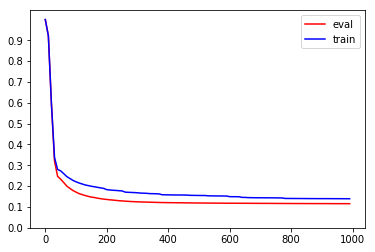

In [38]:
#从最终的训练importnace中看果然是时间序列影响比较大
ret = estimator.evals_result()
train_line = ret['validation_0']['rmspe'][0:1000:10]
eval_line  = ret['validation_1']['rmspe'][0:1000:10]
# evaldata = ret['eval']['rmspe'][0:num_trees:10]
# traindata = ret['train']['rmspe'][0:num_trees:10]
plt.plot(range(0,1000,10),eval_line,color='red',label="eval")
plt.plot(range(0,1000,10),train_line,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()

In [55]:
#获取商店1号的真实数据和预测数据
val_train,val_store,val_test = load_data(Dataset_dir)
val_train = val_train[val_train['Open'] != 0]
val_train = pd.merge(val_train, val_store, on='Store')
test_train = val_train[val_train.Store == 1]
train_val1 = pd.DataFrame(test_train,columns=['Sales'])
train_val1 = np.log1p(train_val1)
build_feature(test_train,True)
test_train.drop('Sales',axis=1,inplace=True)
pred = estimator.predict(test_train)
train_val2 = pd.DataFrame(pred,columns=['Sales'])

      Sales
0  8.568646
1  8.521384
2  8.472823
3  8.519590
4  8.716536


D:\AnaconDA\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\AnaconDA\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\AnaconDA\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

int64
Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
      Sales
0  8.657778
1  8.510493
2  8.473204
3  8.542768
4  8.691531


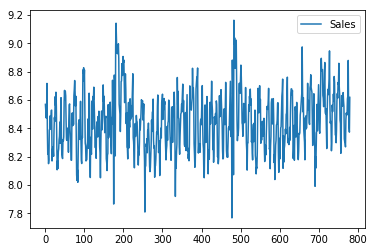

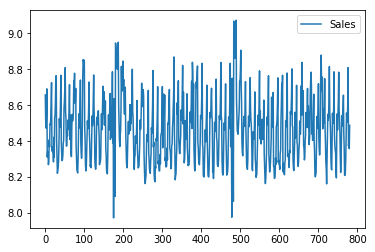

In [57]:
train_val1.plot.line()
train_val2.plot.line()

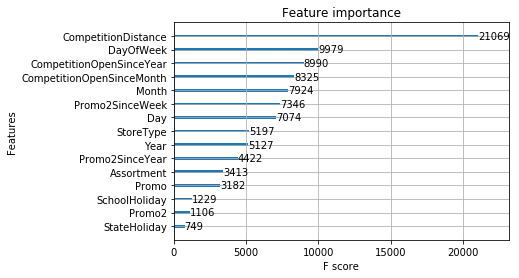

In [60]:
xgb.plot_importance(estimator.get_booster())

In [35]:
#预测测试数据
regetTest = pd.read_csv("./test.csv")
replaceID = regetTest[regetTest.Open == 0.0]['Id']
print(replaceID.values)
test_probs = estimator.predict(test)
result = pd.DataFrame({"Id": TESTID , 'Sales': np.exp(test_probs)})
result.loc[result['Id'].isin(replaceID.values),'Sales'] = 0

[  544   677   841 ... 40230 40231 40232]


In [36]:
#预测测试数据输出
result.to_csv("xgboost_submission.csv", index=False)